In [1]:
# Imports

import matplotlib.pyplot as plt
import numpy as np

import ray
from ray.rllib.algorithms.ppo import PPOConfig

from src.parsers import HMParser
from src.resources import Vehicle
from src.algorithms.rl import EVMultiAgent_v3

2023-12-01 11:56:59,924	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


In [2]:
# Data parsing

data = HMParser(file_path='C:/Users/camar/DataspellProjects/phd_thesis/pyecom/data/EC_V4.xlsx',
                ec_id=1)
data.parse()

In [3]:
# Create EVs

evs = []
for ev in np.arange(data.vehicle['e_capacity_max'].shape[0]):
    new_ev = Vehicle(name='ev_{:02d}'.format(ev + 1),
                     value=data.vehicle['min_technical_soc'][ev] * data.vehicle['e_capacity_max'][ev],
                     lower_bound=np.ones(data.vehicle['schedule_charge'][ev].shape) * \
                                 data.vehicle['min_technical_soc'][ev] * data.vehicle['e_capacity_max'][ev],
                     upper_bound=np.ones(data.vehicle['schedule_charge'][ev].shape) * \
                                 data.vehicle['e_capacity_max'][ev],
                     cost = np.zeros(data.vehicle['schedule_charge'][ev].shape),
                     cost_discharge=np.ones(data.vehicle['schedule_charge'][ev].shape) * \
                                    data.vehicle['discharge_price'][ev, 0],
                     cost_charge=np.ones(data.vehicle['schedule_charge'][ev].shape) * \
                                 data.vehicle['charge_price'][ev, 0],
                     capacity_max=data.vehicle['e_capacity_max'][ev],
                     initial_charge=data.vehicle['min_technical_soc'][ev] * data.vehicle['e_capacity_max'][ev],
                     min_charge=data.vehicle['min_technical_soc'][ev] * data.vehicle['e_capacity_max'][ev],
                     discharge_efficiency=data.vehicle['charge_efficiency'][ev],
                     charge_efficiency=data.vehicle['charge_efficiency'][ev],
                     schedule_connected=data.vehicle['schedule'][ev],
                     schedule_discharge=data.vehicle['schedule_discharge'][ev],
                     schedule_charge=data.vehicle['schedule_charge'][ev],
                     schedule_requirement_soc=data.vehicle['schedule_departure_soc'][ev],
                     schedule_arrival_soc=data.vehicle['schedule_arrival_soc'][ev]
                     )
    evs.append(new_ev)

In [4]:
# Create and test environment to check if everything is working

temp_env = EVMultiAgent_v3(resources=evs,
                           penalty_action_coefficient=1.0,
                           penalty_not_charged=100.0,
                           energy_price=data.peers['buy_price'][0, :])
temp_env.reset()
terminations = truncations = {a: False for a in temp_env.agents}
terminations['__all__'] = False
truncations['__all__'] = False
while not terminations['__all__'] and not truncations['__all__']:
    actions = temp_env.action_space.sample()
    observations, rewards, terminations, truncations, infos = temp_env.step(actions)
print('Terminated: {}'.format(terminations['__all__']))

Terminated: True


In [5]:
# Aux function to assign policies

def assign_policies(env):

    policies = {}
    for agent in env.agents:
        policies[agent] = (None,
                           env.observation_space[agent],
                           env.action_space[agent],
                           {})
    return policies

policies = assign_policies(env=temp_env)

In [6]:
from ray.tune import register_env

# Create an RLlib Algorithm instance from a PPOConfig to learn how to
# act in the above environment.

ray.shutdown()
ray.init()

register_env("EC_EV_Multi", lambda config: EVMultiAgent_v3(resources=evs,
                                                           penalty_action_coefficient=1.0,
                                                           penalty_not_charged=100.0,
                                                           energy_price=data.peers['buy_price'][0, :]))

config = (
    PPOConfig()
    .environment(env="EC_EV_Multi")
    .training(
        train_batch_size=240,
        lr=2e-4,
        gamma=0.99,
        use_critic=True,
        use_gae=True)
    .resources(num_gpus=0)
    .framework('torch')# 'tf2', eager_tracing=False)
    .rollouts(num_rollout_workers=10, rollout_fragment_length=24)
    .multi_agent(policies=policies,
                 policy_mapping_fn=lambda agent_id, episode, worker, **kwargs: agent_id)
)
algo = config.build()

# Train for n iterations and report results (mean episode rewards).
# Optimal episode reward is 0.0
checkpoint = None
MAX_ITER = 100
RESULTS = []
for i in range(MAX_ITER):
    results = algo.train()
    RESULTS.append(results)
    print(f"Iter: {i}; avg. reward={results['episode_reward_mean']}")
    if results['episode_reward_mean'] > -20.0:
        checkpoint = algo.save()
        print("checkpoints saved")
        break

    # Save the checkpoint to disk every 10 iterations.
    if (i % 10 == 0) or (i == MAX_ITER - 1):
        checkpoint = algo.save()
        print("checkpoints saved")

2023-12-01 11:57:09,767	INFO worker.py:1642 -- Started a local Ray instance.
2023-12-01 11:57:12,424	WARNING algorithm_config.py:2578 -- Setting `exploration_config={}` because you set `_enable_rl_module_api=True`. When RLModule API are enabled, exploration_config can not be set. If you want to implement custom exploration behaviour, please modify the `forward_exploration` method of the RLModule at hand. On configs that have a default exploration config, this must be done with `config.exploration_config={}`.
2023-12-01 11:57:12,428	WARNING algorithm_config.py:2578 -- Setting `exploration_config={}` because you set `_enable_rl_module_api=True`. When RLModule API are enabled, exploration_config can not be set. If you want to implement custom exploration behaviour, please modify the `forward_exploration` method of the RLModule at hand. On configs that have a default exploration config, this must be done with `config.exploration_config={}`.
C:\Users\camar\DataspellProjects\phd_thesis\pyeco

Iter: 0; avg. reward=nan
checkpoints saved
Iter: 1; avg. reward=-134.85256745113253
Iter: 2; avg. reward=-209.0948080333187
Iter: 3; avg. reward=-164.38505468268002
Iter: 4; avg. reward=-154.43129210290994
Iter: 5; avg. reward=-144.50042954176593
Iter: 6; avg. reward=-134.6249236964377
Iter: 7; avg. reward=-124.68117010894704
Iter: 8; avg. reward=-122.24281448341958
Iter: 9; avg. reward=-115.86492069254778
Iter: 10; avg. reward=-114.728497885214
checkpoints saved
Iter: 11; avg. reward=-106.729449433624
Iter: 12; avg. reward=-84.90274955616313
Iter: 13; avg. reward=-81.83664264766472
Iter: 14; avg. reward=-76.82823009101077
Iter: 15; avg. reward=-72.7492671454613
Iter: 16; avg. reward=-68.61119848246756
Iter: 17; avg. reward=-69.51762870273342
Iter: 18; avg. reward=-66.36862478656931
Iter: 19; avg. reward=-65.30799555894106
Iter: 20; avg. reward=-59.27449804236118
checkpoints saved
Iter: 21; avg. reward=-56.17074708718915
Iter: 22; avg. reward=-51.996795775274656
Iter: 23; avg. reward=-

In [7]:
# Check the actions (inference)

temp_env = EVMultiAgent_v3(resources=evs,
                           penalty_action_coefficient=1.0,
                           penalty_not_charged=100.0,
                           energy_price=data.peers['buy_price'][0, :])
obs, info = temp_env.reset()
temp_env.reset()
terminations = truncations = {a: False for a in temp_env.agents}
terminations['__all__'] = False
truncations['__all__'] = False
episode_info = []
while not terminations['__all__'] and not truncations['__all__']:
    print('Timestep: {}'.format(temp_env.current_timestep))
    action_dict = {a: algo.compute_single_action(observation=obs[a], policy_id=a) for a in temp_env.agents}
    obs, reward, terminations, truncations, info = temp_env.step(action_dict)
    episode_info.append(info)

Timestep: 0
Timestep: 1
Timestep: 2
Timestep: 3
Timestep: 4
Timestep: 5
Timestep: 6
Timestep: 7
Timestep: 8
Timestep: 9
Timestep: 10
Timestep: 11
Timestep: 12
Timestep: 13
Timestep: 14
Timestep: 15
Timestep: 16
Timestep: 17
Timestep: 18
Timestep: 19
Timestep: 20
Timestep: 21
Timestep: 22
Timestep: 23
Timestep: 24


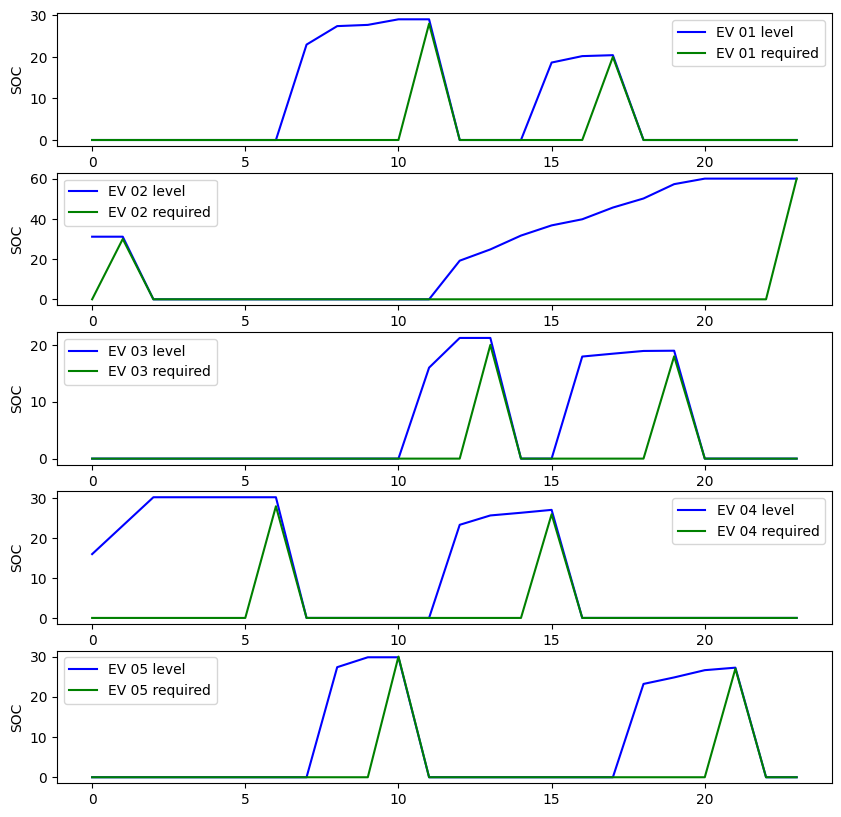

In [8]:
# Plot in separate columns and for each subplot also plot the price

fig, axs = plt.subplots(5, 1, figsize=(10, 10))
for e in range(1, 6):
    # EV Battery level
    temp_ev = [episode_info[i]['ev_{:02d}'.format(e)]['updated_soc']
               for i in range(len(episode_info) - 1)]
    axs[e-1].plot(temp_ev,
                  label='EV {:02d} level'.format(e), color = 'blue')

    temp_req = [episode_info[i]['ev_{:02d}'.format(e)]['required_soc']
                for i in range(len(episode_info) - 1)]
    axs[e-1].plot(temp_req,
                  label='EV {:02d} required'.format(e), color = 'green')
    axs[e-1].legend()
    axs[e-1].set_ylabel('SOC')

plt.show()